In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

if torch.cuda.is_available():
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
model = NeuralNetwork().to(device)

Using cuda device
GPU device name: NVIDIA GeForce RTX 4050 Laptop GPU
Number of GPUs: 1


### Hyperparameters
* Num of Epochs
* Batch size
* Learning Rate

In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Optimization Loop
* the train loop
  * iterate over batches
  * forward pass
  * loss calculation
  * backward pass
  * parameter update
* the validation / test loop
  * iterate over batches
  * forward pass (in inference mode)
  * loss / metric accumulation

In [ ]:
# https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_fn = nn.CrossEntropyLoss()

# https://docs.pytorch.org/docs/stable/optim.html
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # stochastic gradient descent(mini-batch gradient descent)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_train_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(next(model.parameters()).device)
        y = y.to(next(model.parameters()).device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        current_loss = loss.item()
        epoch_train_losses.append(current_loss)
        
    return epoch_train_losses

In [ ]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(next(model.parameters()).device) # remember to move to the device before training
            y = y.to(next(model.parameters()).device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches 
    accuracy = correct / size
    
    return test_loss, accuracy  # 返回测试损失和准确率

In [7]:
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 添加用于记录数据的列表
all_train_losses = []   # 记录所有batch的训练损失
all_test_losses = []    # 记录每个epoch的测试损失
all_test_accuracies = []  # 记录每个epoch的测试准确率

epochs = 10
for t in tqdm(range(epochs)):
    
    # 训练并获取当前epoch的训练损失
    epoch_train_losses = train_loop(train_dataloader, model, loss_fn, optimizer)
    all_train_losses.extend(epoch_train_losses)  # 保存所有batch损失
    
    # 测试并获取测试损失和准确率
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_acc)
    
print("Done!")

100%|██████████| 10/10 [01:21<00:00,  8.17s/it]

Done!


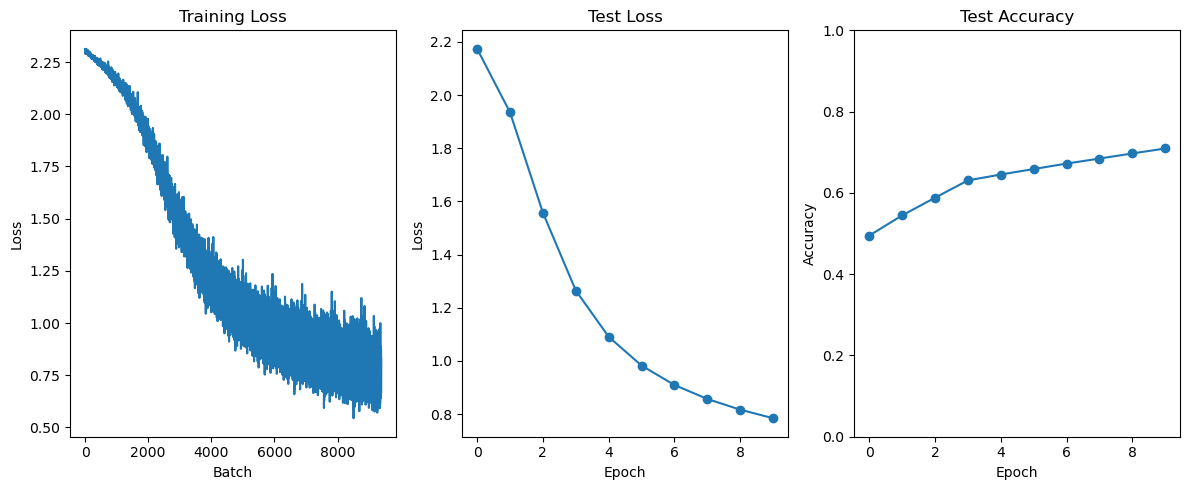

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(all_train_losses)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)

plt.plot(all_test_losses, 'o-')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(all_test_accuracies, 'o-')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Load / Save the model

In [9]:
torch.save(model, 'model_entire.pth') # 保存整个模型
torch.save(model.state_dict(), 'model_state_dict.pth') # 只保存参数

In [10]:
entire_model = torch.load('model_entire.pth', weights_only = False) # 加载整个模型
entire_model = entire_model.to(device)
entire_model.eval()
print(entire_model)
print(test_loop(test_dataloader, entire_model, loss_fn))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
(0.7846559409502964, 0.7093)


In [11]:
loaded_model = NeuralNetwork().to(device)
state_dict = torch.load('model_state_dict.pth')
loaded_model.load_state_dict(state_dict)
loaded_model.eval()
test_loop(test_dataloader, loaded_model, loss_fn)

/tmp/ipykernel_59225/1968175487.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model_state_dict.pth')


(0.7846559409502964, 0.7093)

In [ ]:
for (name1, param1), (name2, param2) in zip(loaded_model.named_parameters(), entire_model.named_parameters()):
    if not torch.allclose(param1, param2, atol=1e-6):
        print(f"Parameter mismatch: {name1}, {param1}, {param2}")
    else:
        print(f"Parameter match: {name1}")

Parameter match: linear_relu_stack.0.weight
Parameter match: linear_relu_stack.0.bias
Parameter match: linear_relu_stack.2.weight
Parameter match: linear_relu_stack.2.bias
Parameter match: linear_relu_stack.4.weight
Parameter match: linear_relu_stack.4.bias
